<a href="https://colab.research.google.com/github/arthurziegler/pytorch-deep-learning-course/blob/main/Notebooks/PyTorch_Autoregressive_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

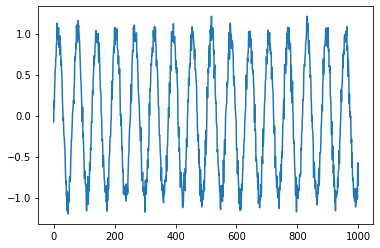

In [36]:
# make the original data
N = 1000
series = np.sin(0.1*np.arange(N)) + np.random.randn(N)*0.1

# plot it
plt.plot(series)
plt.show()

In [37]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10 
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

print("X.shape", np.asarray(X).shape, "Y.shape", np.asarray(Y).shape)
X = np.array(X).reshape(-1, T)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("N number of windows", N)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (990, 10) Y.shape (990,)
N number of windows 990
X.shape (990, 10) Y.shape (990, 1)


In [38]:
### try autoregressive linear model
model = nn.Linear(T, 1)

In [39]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [40]:
# Make inputs and targets
# We don't want to split data randomly. A forecasting model has to predict the future, so we can't train it with points that are in that future(testing on a model trained with more recent data then the test data)
# Because of this we will train with the first half of the dataset and test with the second.
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [41]:
# Training
# Using full gd instead of batch gd because or dataset is quite small and does not require it
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=200):

  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
      
    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save losses
    train_losses[it] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()
      
    if (it + 1) % 5 == 0:
      print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
  
  return train_losses, test_losses

In [42]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/200, Train Loss: 0.6472, Test Loss: 0.4452
Epoch 10/200, Train Loss: 0.1941, Test Loss: 0.2156
Epoch 15/200, Train Loss: 0.0207, Test Loss: 0.0429
Epoch 20/200, Train Loss: 0.0585, Test Loss: 0.0386
Epoch 25/200, Train Loss: 0.0768, Test Loss: 0.0661
Epoch 30/200, Train Loss: 0.0432, Test Loss: 0.0489
Epoch 35/200, Train Loss: 0.0187, Test Loss: 0.0222
Epoch 40/200, Train Loss: 0.0171, Test Loss: 0.0160
Epoch 45/200, Train Loss: 0.0205, Test Loss: 0.0193
Epoch 50/200, Train Loss: 0.0196, Test Loss: 0.0202
Epoch 55/200, Train Loss: 0.0164, Test Loss: 0.0176
Epoch 60/200, Train Loss: 0.0145, Test Loss: 0.0163
Epoch 65/200, Train Loss: 0.0141, Test Loss: 0.0158
Epoch 70/200, Train Loss: 0.0141, Test Loss: 0.0156
Epoch 75/200, Train Loss: 0.0138, Test Loss: 0.0151
Epoch 80/200, Train Loss: 0.0136, Test Loss: 0.0149
Epoch 85/200, Train Loss: 0.0135, Test Loss: 0.0148
Epoch 90/200, Train Loss: 0.0134, Test Loss: 0.0147
Epoch 95/200, Train Loss: 0.0133, Test Loss: 0.0146
Epoch 100/200

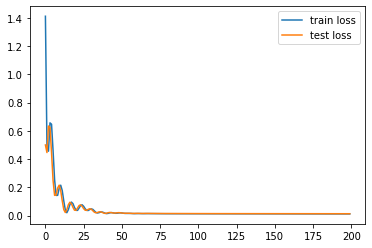

In [43]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [44]:
# "Wrong" forecast using true targets

validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = 0

while len(validation_predictions) < len(validation_target):
  input_ = X_test[i].view(1, -1)
  p = model(input_)[0,0].item() # outputs 1x1 array -> scalar
  i += 1
  
  # update the predictions list
  validation_predictions.append(p)

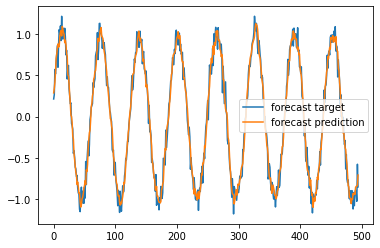

In [45]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [46]:
# Forecast future values (use only self-predictions for making future predictions)

validation_target = Y[-N//2:]
validation_predictions = []

# last train input
# 1-D array of length T
last_x = torch.from_numpy(X[-N//2].astype(np.float32))
print(last_x.shape)

while len(validation_predictions) < len(validation_target):
  input_ = last_x.view(1, -1)
  p = model(input_)
  # [0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p[0,0].item())
  
  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))

torch.Size([10])


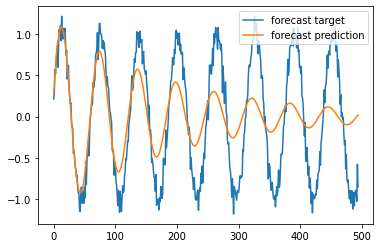

In [47]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()